<a href="https://colab.research.google.com/github/jee365/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04. 위성 이미지 분류

### 4-1 텐서플로 데이터셋 로드

In [5]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

#tensorflow datasets 활용
import tensorflow_datasets as tfds

In [6]:
DATA_DIR = 'dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteT7YAQC/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [7]:
#메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

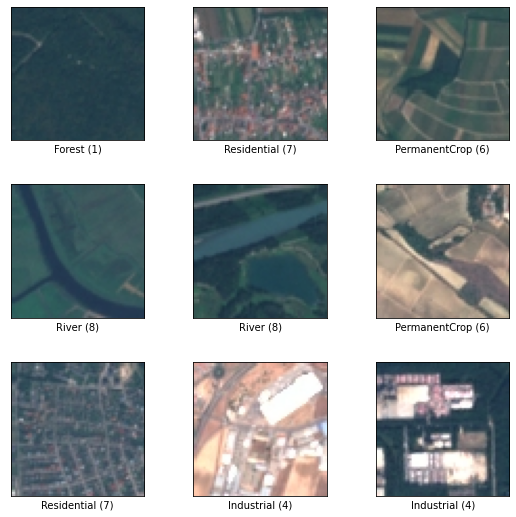

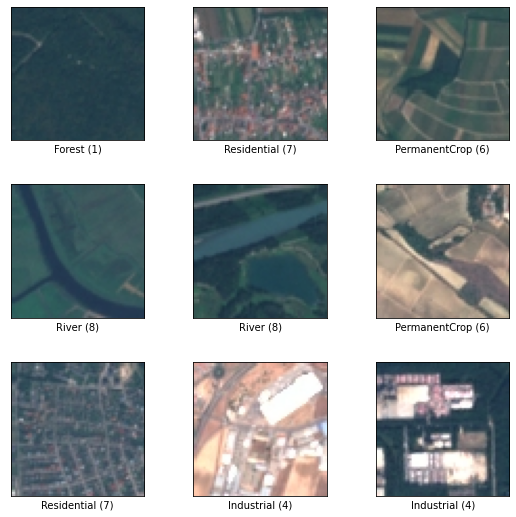

In [8]:
#데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

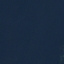
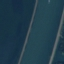
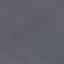
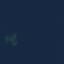
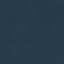
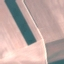
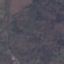
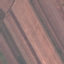
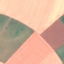
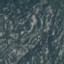

In [9]:
#as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [10]:
#목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [11]:
#숫자 레이블을 활용해 문자열 메타 데이터로 전환
print(info.features["label"].int2str(6))

PermanentCrop


### 4-2 데이터 전처리

map 함수는 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 매우 유용함

num_parallel_calls 옵션을 오토튠으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화

오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있음

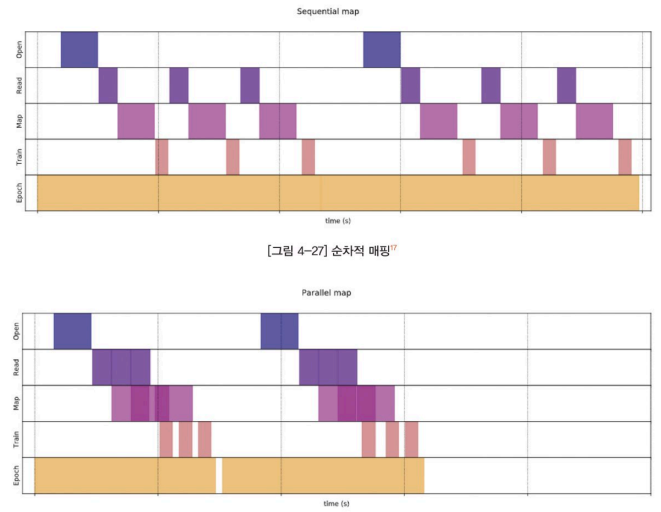

prefetch() 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리 하도록 시스템을 조율함

In [12]:
#데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255. #0~1 정규화, float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3 모델 훈련 및 검증

In [13]:
#Sequential API를 사용하여 샘플 모델 생성
def build_model():

  model=tf.keras.Sequential([
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2)),

                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2)),

                             #Classifier 출력층
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

  ])

  return model

model = build_model()

In [18]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs = 50)

Epoch 1/50
338/338 [==============================] - 176s 515ms/step - loss: 1.7800 - accuracy: 0.3732 - val_loss: 1.7092 - val_accuracy: 0.4424
Epoch 2/50
338/338 [==============================] - 181s 536ms/step - loss: 1.3218 - accuracy: 0.5329 - val_loss: 0.9753 - val_accuracy: 0.6744
Epoch 3/50
338/338 [==============================] - 217s 643ms/step - loss: 1.0992 - accuracy: 0.6178 - val_loss: 0.8727 - val_accuracy: 0.6913
Epoch 4/50
338/338 [==============================] - 222s 656ms/step - loss: 0.9560 - accuracy: 0.6689 - val_loss: 0.6858 - val_accuracy: 0.7761
Epoch 5/50
338/338 [==============================] - 238s 704ms/step - loss: 0.8586 - accuracy: 0.7043 - val_loss: 0.6149 - val_accuracy: 0.7970
Epoch 6/50
338/338 [==============================] - 260s 769ms/step - loss: 0.8049 - accuracy: 0.7263 - val_loss: 0.6084 - val_accuracy: 0.8026
Epoch 7/50
338/338 [==============================] - 239s 707ms/step - loss: 0.7632 - accuracy: 0.7443 - val_loss: 0.5963 -

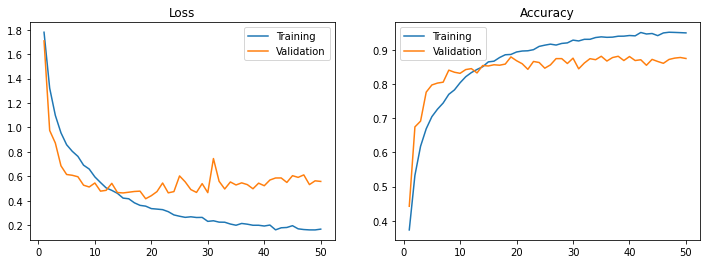

In [20]:
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), acc, label='Training')
  axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 50)

### 4-4 데이터 증강

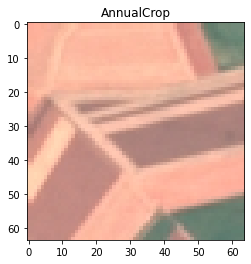

In [15]:
#샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [16]:
#데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):
  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

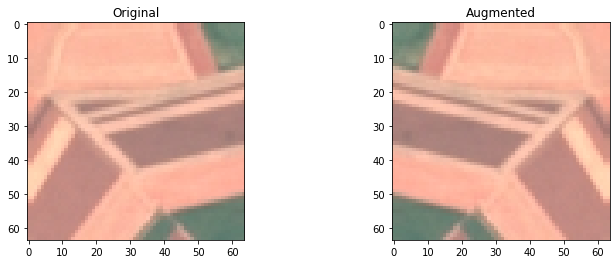

In [17]:
#좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

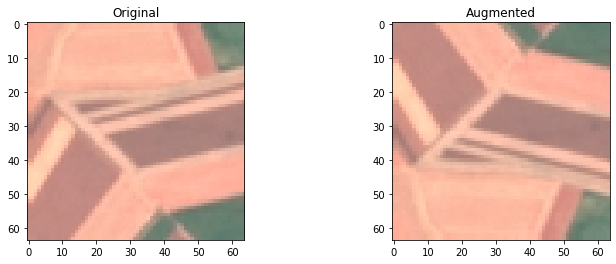

In [18]:
#상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

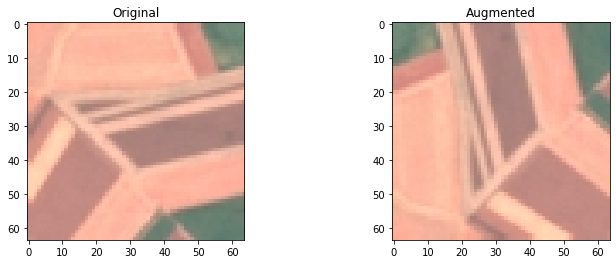

In [19]:
#회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

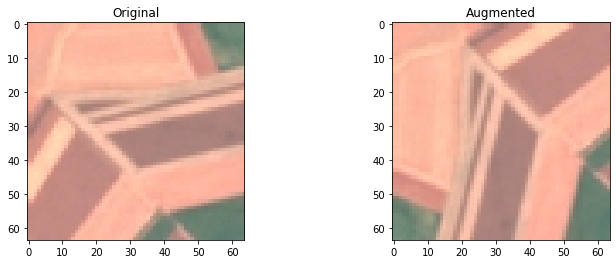

In [20]:
#transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

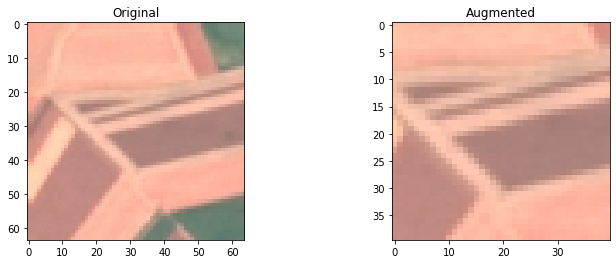

In [21]:
#이미지 자르기1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

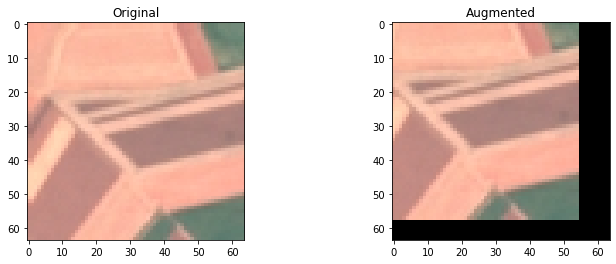

In [22]:
#이미지 자르기2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20) #사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop2)

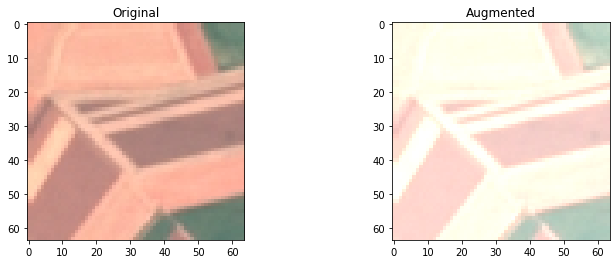

In [23]:
#이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

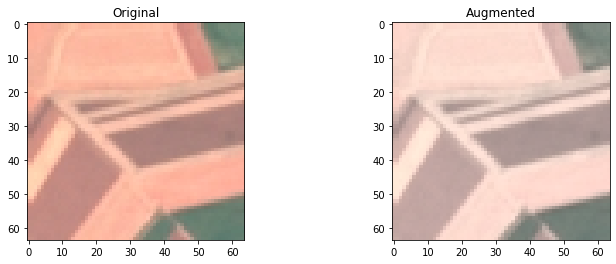

In [24]:
#이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

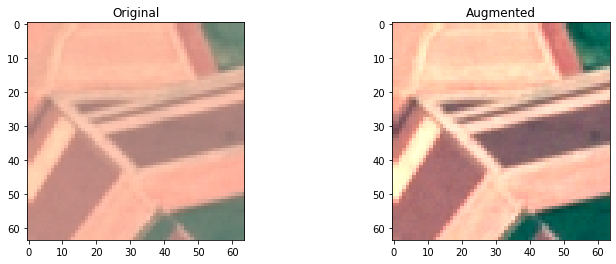

In [25]:
#이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [26]:
#이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image) #좌우 반전
  image = tf.image.random_flip_up_down(image) #상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3) #밝기 변화
  image = tf.image.random_crop(image, size=[64,64,3])

  image = tf.cast(image, tf.float32)/255. # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [33]:
#모델 생성
aug_model = build_model()

#모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 180s 528ms/step - loss: 1.8910 - accuracy: 0.3017 - val_loss: 1.8505 - val_accuracy: 0.3707
Epoch 2/50
338/338 [==============================] - 174s 514ms/step - loss: 1.5858 - accuracy: 0.4075 - val_loss: 1.2710 - val_accuracy: 0.5513
Epoch 3/50
338/338 [==============================] - 176s 518ms/step - loss: 1.4153 - accuracy: 0.4737 - val_loss: 1.1332 - val_accuracy: 0.6056
Epoch 4/50
338/338 [==============================] - 176s 519ms/step - loss: 1.2699 - accuracy: 0.5334 - val_loss: 0.9784 - val_accuracy: 0.6650
Epoch 5/50
338/338 [==============================] - 174s 514ms/step - loss: 1.1770 - accuracy: 0.5715 - val_loss: 0.9352 - val_accuracy: 0.6706
Epoch 6/50
338/338 [==============================] - 174s 514ms/step - loss: 1.0959 - accuracy: 0.6031 - val_loss: 0.8584 - val_accuracy: 0.7193
Epoch 7/50
338/338 [==============================] - 174s 515ms/step - loss: 1.0454 - accuracy: 0.6280 - val_loss: 0.8351 -

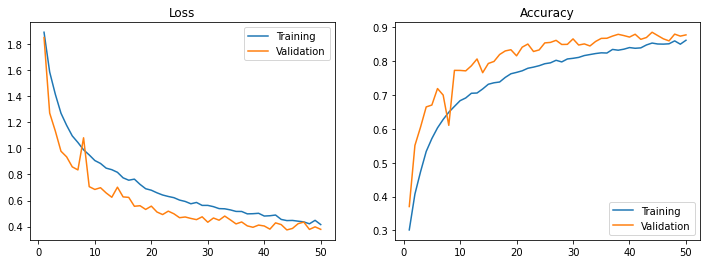

In [34]:
plot_loss_acc(aug_history, 50)

### 4-5 ResNet 사전 학습 모델

include_top = False로 지정해 이미지넷 경진 대회에 맞게 설정된 분류기인 Top 층을 제거

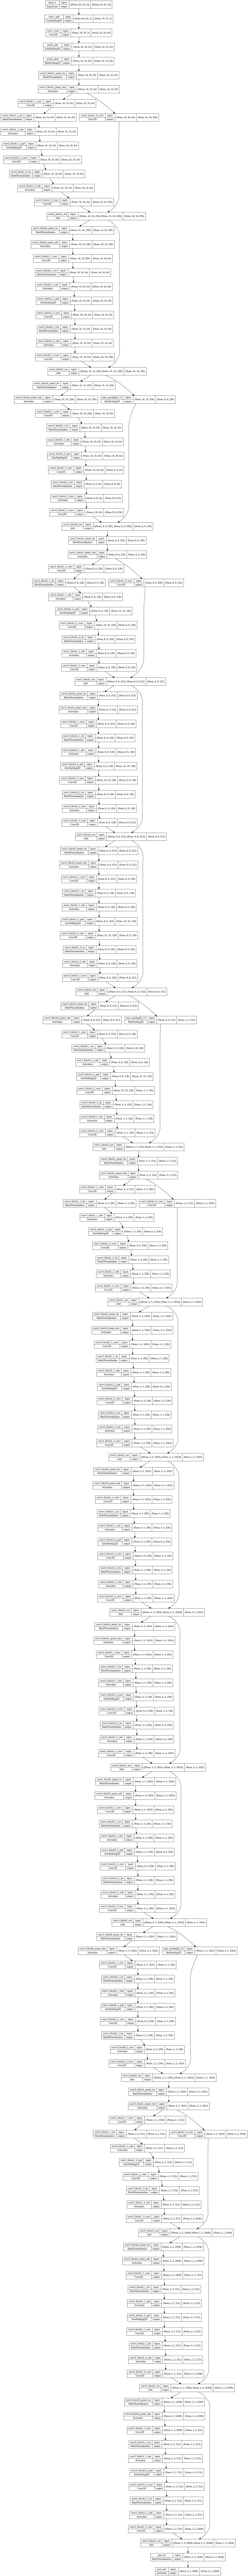

In [29]:
#Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2
from keras.utils.vis_utils import plot_model

pre_trained_base = ResNet50V2(include_top = False, weights = 'imagenet', input_shape=[64,64,3])

#사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

#모델 구조 시각화
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [30]:
#Top 층에 Classifier 추가
def build_transfer_classifier():

  model= tf.keras.Sequential([
                              #Pre-trained Base
                              pre_trained_base,
                              #Classifier 출력층
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(64, activation='relu'),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),

  ])
  return model

#모델 구조
tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               